In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import os
from scipy.stats import spearmanr
from matplotlib.lines import Line2D

In [2]:
def load_config(yaml_path="P4-config.yaml"):
    with open(yaml_path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)
    
config = load_config()

In [3]:
deepseek_output_path = config["output_file_paths"]["deepseek_ratings_output_dir"]
o4_mini_output_path =  config["output_file_paths"]["chatgpt_ratings_output_dir"]

o4_mini_basic_path = os.path.join(o4_mini_output_path, "basic_realworld_test")
o4_mini_basic = pd.read_csv(os.path.join(o4_mini_basic_path, "chatgpt_ratings_basic_realworld_test.csv"))
deepseek_basic_path = os.path.join(deepseek_output_path, "basic_realworld_test")
deepseek_basic = pd.read_csv(os.path.join(deepseek_basic_path, "deepseek_ratings_basic_realworld_test.csv"))

o4_mini_oncology_path = os.path.join(o4_mini_output_path, "onco_realworld_test")
o4_mini_onco = pd.read_csv(os.path.join(o4_mini_oncology_path, "chatgpt_ratings_onco_realworld_test.csv"))
deepseek_onco_path = os.path.join(deepseek_output_path, "onco_realworld_test")
deepseek_onco = pd.read_csv(os.path.join(deepseek_onco_path, "deepseek_ratings_onco_realworld_test.csv"))

o4_mini_reviewer_path = os.path.join(o4_mini_output_path, "reviewer_realworld_test")
o4_mini_reviewer = pd.read_csv(os.path.join(o4_mini_reviewer_path, "chatgpt_ratings_reviewer_realworld_test.csv"))
deepseek_reviewer_path = os.path.join(deepseek_output_path, "reviewer_realworld_test")
deepseek_reviewer = pd.read_csv(os.path.join(deepseek_reviewer_path, "deepseek_ratings_reviewer_realworld_test.csv"))


In [4]:
o4_mini_basic.head()

,record_id,Drug,Summary,accurate,organized,comprehensible,succinct
0,0,Metformin,"{\n ""Mechanism"": ""Metformin is an oral anti-h...",5,5,4,2
1,1,Pioglitazone,"<Output>\n{\n ""Mechanism"": ""Pioglitazone is a...",5,5,5,4
2,2,Alogliptin,"<Output>\n{\n ""Mechanism"": ""Alogliptin is a D...",5,5,5,4
3,3,Linagliptin,"<Output>\n{\n ""Mechanism"": ""Linagliptin is a ...",2,5,4,3
4,4,Sitagliptin,"{\n ""Mechanism"": ""Sitagliptin is a DPP-4 inhi...",5,5,5,3


## Simple statistics

In [5]:
def get_stats(df):
    categories = ["accurate", "organized", "comprehensible", "succinct"]

    stats_df = pd.DataFrame({
        "average": df[categories].mean(),
        "median": df[categories].median(),
        "std_dev": df[categories].std()
    })

    return stats_df


In [6]:
def compare(o4_df, deep_df):
    o4_stats = get_stats(o4_df)
    deep_stats = get_stats(deep_df)
    merged = pd.concat({"o4_mini": o4_stats["average"],
                        "deepseek": deep_stats["average"]}, axis=1)
    return merged

basic_compare = compare(o4_mini_basic, deepseek_basic)
onco_compare = compare(o4_mini_onco, deepseek_onco)
reviewer_compare = compare(o4_mini_reviewer, deepseek_reviewer)


In [7]:
print("Basic compare:")
print(basic_compare)

print("\nOncology compare:")
print(onco_compare)

print("\nReviewer compare:")
print(reviewer_compare)


Basic compare:
                 o4_mini  deepseek
accurate        3.827586      3.75
organized       4.793103      5.00
comprehensible  4.482759      5.00
succinct        3.275862      4.50

Oncology compare:
                 o4_mini  deepseek
accurate        3.655172     3.750
organized       5.000000     5.000
comprehensible  4.724138     5.000
succinct        3.655172     4.625

Reviewer compare:
                 o4_mini  deepseek
accurate        4.142857       4.6
organized       5.000000       4.6
comprehensible  4.714286       4.8
succinct        3.285714       3.8


In [8]:
# find outliers
def find_outliers(df):
    categories = ["accurate", "organized", "comprehensible", "succinct"]
    
    # store all outlier drug names
    all_outliers = set()

    for category in categories:
        mean = df[category].mean()
        std_dev = df[category].std()
        threshold = mean - 2 * std_dev

        # find drugs below threshold
        outliers = df[df[category] < threshold]["Drug"].tolist()

        # add them to the global set of outliers
        all_outliers.update(outliers)

    return list(all_outliers)


basic_o4_outliers = find_outliers(o4_mini_basic)
basic_deep_outliers = find_outliers(deepseek_basic)

onco_o4_outliers = find_outliers(o4_mini_onco)
onco_deep_outliers = find_outliers(deepseek_onco)

reviewer_o4_outliers = find_outliers(o4_mini_reviewer)
reviewer_deep_outliers = find_outliers(deepseek_reviewer)




In [9]:
print(basic_o4_outliers)
print(basic_deep_outliers)
print(onco_o4_outliers)
print(onco_deep_outliers)
print(reviewer_o4_outliers)
print(reviewer_deep_outliers)

['Exenatide', 'Empagliflozin']
[]
[]
['Lorazepam']
['Escitalopram', 'Alprazolam', 'Dapagliflozin']
[]


In [10]:
basic_o4_mini_stats = get_stats(o4_mini_basic)
basic_deepseek_stats = get_stats(deepseek_basic)
onco_o4_mini_stats = get_stats(o4_mini_onco)
onco_deepseek_stats = get_stats(deepseek_onco)
reviewer_o4_mini_stats = get_stats(o4_mini_reviewer)
reviewer_deepseek_stats = get_stats(deepseek_reviewer)

### add token len

In [19]:
def add_token_len(df, text_col="Summary"):
    # safe string + approximate tokens
    s = df[text_col].fillna("").astype(str)
    df = df.copy()
    df["n_tokens"] = (s.str.len() / 4).round().astype(int)
    return df


o4_mini_basic = add_token_len(o4_mini_basic)
deepseek_basic = add_token_len(deepseek_basic)

o4_mini_onco = add_token_len(o4_mini_onco)
deepseek_onco = add_token_len(deepseek_onco)

o4_mini_reviewer = add_token_len(o4_mini_reviewer)
deepseek_reviewer = add_token_len(deepseek_reviewer)


In [20]:
def to_long(df, dataset_name, model_name):
    categories = ["accurate", "organized", "comprehensible", "succinct"]
    out = df[["Drug", "record_id", "n_tokens", *categories]].copy()
    out["Dataset"] = dataset_name
    out["Model"] = model_name
    return out

all_df = pd.concat([
    to_long(o4_mini_basic, "Basic", "o4-mini"),
    to_long(deepseek_basic, "Basic", "DeepSeek"),
    to_long(o4_mini_onco, "Onco", "o4-mini"),
    to_long(deepseek_onco, "Onco", "DeepSeek"),
    to_long(o4_mini_reviewer, "Reviewer", "o4-mini"),
    to_long(deepseek_reviewer, "Reviewer", "DeepSeek"),
], ignore_index=True)

plot_df = all_df.melt(
    id_vars=["Drug", "record_id", "n_tokens", "Dataset", "Model"],
    value_vars=["accurate", "organized", "comprehensible", "succinct"],
    var_name="Metric",
    value_name="Score"
).dropna()


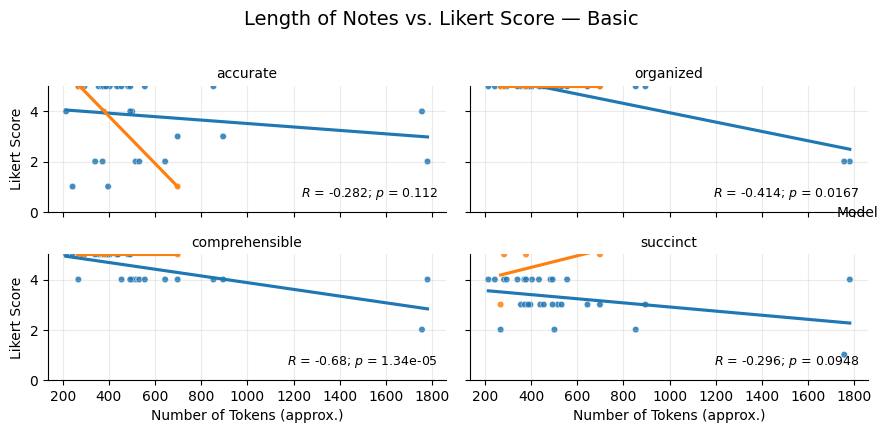

C:\Users\Admin\AppData\Local\Temp\ipykernel_11840\1922469323.py:30: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = spearmanr(data["n_tokens"], data["Score"], nan_policy="omit")


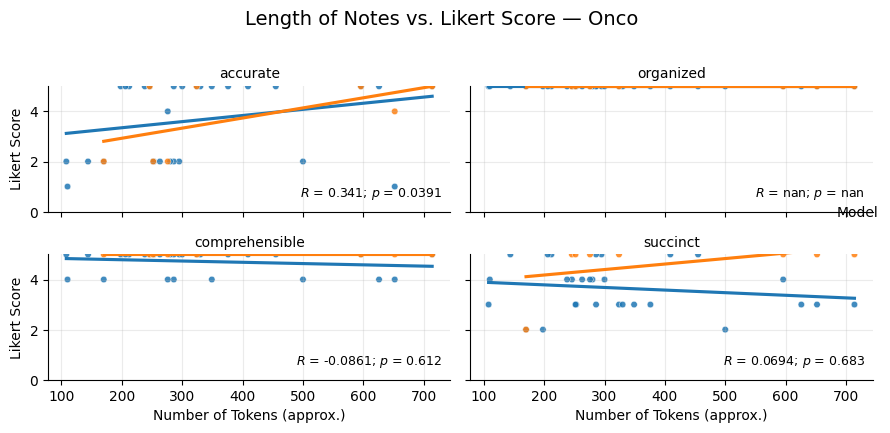

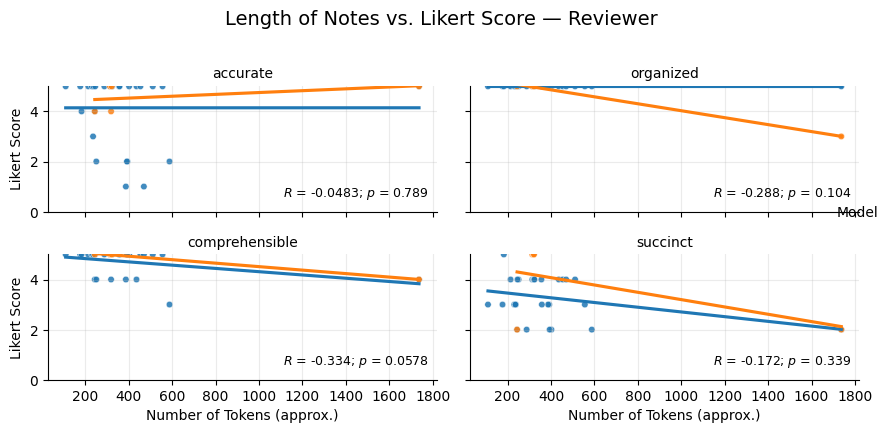

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

def plot_tokens_vs_score_by_dataset(plot_df, dataset_name):
    df = plot_df[plot_df["Dataset"] == dataset_name].copy()
    metrics = ["accurate", "organized", "comprehensible", "succinct"]

    g = sns.FacetGrid(
        df, col="Metric", col_wrap=2, height=2.1, aspect=2.0,
        sharex=True, sharey=True
    )

    def panel(data, **kws):
        ax = plt.gca()
        # scatter by model
        sns.scatterplot(
            data=data, x="n_tokens", y="Score",
            hue="Model", alpha=0.85, s=22, ax=ax, legend=False
        )
        # regression lines per model
        for model in data["Model"].unique():
            sub = data[data["Model"] == model]
            sns.regplot(
                data=sub, x="n_tokens", y="Score",
                scatter=False, ci=None, ax=ax
            )

        # spearman on pooled points (matches many papers)
        rho, p = spearmanr(data["n_tokens"], data["Score"], nan_policy="omit")
        ax.text(
            0.98, 0.08, f"$R$ = {rho:.3g}; $p$ = {p:.3g}",
            transform=ax.transAxes, ha="right", va="bottom", fontsize=9
        )
        ax.set_ylim(0, 5)
        ax.grid(True, alpha=0.25)

    g.map_dataframe(panel)
    g.set_axis_labels("Number of Tokens (approx.)", "Likert Score")
    g.set_titles("{col_name}")
    g.fig.suptitle(f"Length of Notes vs. Likert Score — {dataset_name}", y=1.02, fontsize=14)

    # add a single legend for models
    handles, labels = plt.gca().get_legend_handles_labels()
    g.add_legend(title="Model")



    plt.tight_layout()
    plt.show()

plot_tokens_vs_score_by_dataset(plot_df, "Basic")
plot_tokens_vs_score_by_dataset(plot_df, "Onco")
plot_tokens_vs_score_by_dataset(plot_df, "Reviewer")
